In [1]:
# Cell 1: Load Data  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import confusion_matrix  

OUTPUT_DIR = r"D:\data mining\appendix"  

umap_embeddings = np.load(f'{OUTPUT_DIR}/umap_embeddings.npy')  
true_labels = np.load(f'{OUTPUT_DIR}/true_labels.npy')  

class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']  
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#C7CEEA']  




Data loaded successfully


In [2]:

# Cell 2: Re-run Clustering (if needed)  
from sklearn.cluster import KMeans  
from sklearn.mixture import GaussianMixture  
from scipy.optimize import linear_sum_assignment  

def align_clusters(true_labels, pred_labels):  
    n_clusters = len(np.unique(pred_labels))  
    n_classes = len(np.unique(true_labels))  
    confusion = np.zeros((n_clusters, n_classes))  
    for i in range(len(true_labels)):  
        confusion[pred_labels[i], true_labels[i]] += 1  
    row_ind, col_ind = linear_sum_assignment(-confusion)  
    mapping = {row: col for row, col in zip(row_ind, col_ind)}  
    aligned_labels = np.array([mapping.get(label, label) for label in pred_labels])  
    return aligned_labels, mapping  

kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)  
kmeans_labels = kmeans.fit_predict(umap_embeddings)  
kmeans_aligned, _ = align_clusters(true_labels, kmeans_labels)  

gmm = GaussianMixture(n_components=6, random_state=42, covariance_type='full')  
gmm_labels = gmm.fit_predict(umap_embeddings)  
gmm_aligned, _ = align_clusters(true_labels, gmm_labels)  


Clustering complete


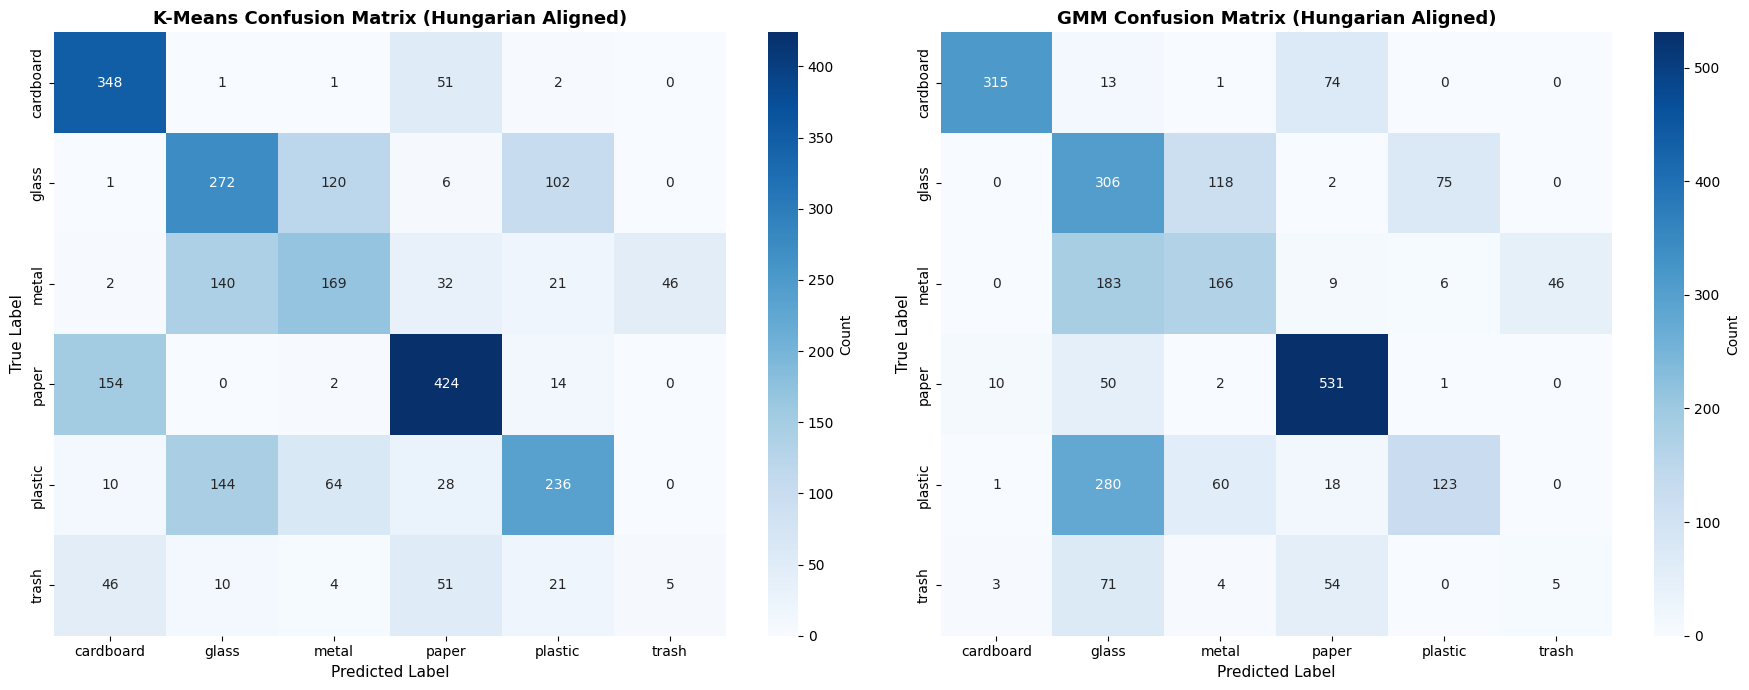

In [3]:

# Cell 3: Confusion Matrices  
fig, axes = plt.subplots(1, 2, figsize=(18, 7))  

# K-Means  
cm_kmeans = confusion_matrix(true_labels, kmeans_aligned)  
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues',   
           xticklabels=class_names, yticklabels=class_names,  
           ax=axes[0], cbar_kws={'label': 'Count'})  
axes[0].set_title('K-Means Confusion Matrix (Hungarian Aligned)',   
                 fontsize=13, fontweight='bold')  
axes[0].set_xlabel('Predicted Label', fontsize=11)  
axes[0].set_ylabel('True Label', fontsize=11)  

# GMM  
cm_gmm = confusion_matrix(true_labels, gmm_aligned)  
sns.heatmap(cm_gmm, annot=True, fmt='d', cmap='Blues',   
           xticklabels=class_names, yticklabels=class_names,  
           ax=axes[1], cbar_kws={'label': 'Count'})  
axes[1].set_title('GMM Confusion Matrix (Hungarian Aligned)',   
                 fontsize=13, fontweight='bold')  
axes[1].set_xlabel('Predicted Label', fontsize=11)  
axes[1].set_ylabel('True Label', fontsize=11)  

plt.tight_layout()  
plt.savefig(f'{OUTPUT_DIR}/05_confusion_matrices.png', dpi=300, bbox_inches='tight')  
plt.show()  


In [9]:

# Cell 4: Confusion Matrix Analysis  
print("K-Means Confusion Matrix:")  
print(cm_kmeans)  
print(f"\nDiagonal sum (correct): {np.trace(cm_kmeans)}")  
print(f"Total: {cm_kmeans.sum()}")  
print(f"Accuracy: {np.trace(cm_kmeans)/cm_kmeans.sum():.4f}")  

print("\n" + "="*60)  

print("\nGMM Confusion Matrix:")  
print(cm_gmm)  
print(f"\nDiagonal sum (correct): {np.trace(cm_gmm)}")  
print(f"Total: {cm_gmm.sum()}")  
print(f"Accuracy: {np.trace(cm_gmm)/cm_gmm.sum():.4f}")



K-Means Confusion Matrix:
[[348   1   1  51   2   0]
 [  1 272 120   6 102   0]
 [  2 140 169  32  21  46]
 [154   0   2 424  14   0]
 [ 10 144  64  28 236   0]
 [ 46  10   4  51  21   5]]

Diagonal sum (correct): 1454
Total: 2527
Accuracy: 0.5754


GMM Confusion Matrix:
[[315  13   1  74   0   0]
 [  0 306 118   2  75   0]
 [  0 183 166   9   6  46]
 [ 10  50   2 531   1   0]
 [  1 280  60  18 123   0]
 [  3  71   4  54   0   5]]

Diagonal sum (correct): 1446
Total: 2527
Accuracy: 0.5722


In [10]:


# Cell 5: Cluster Movement Analysis  
moved = kmeans_aligned != gmm_aligned  
movement_rate = moved.sum() / len(moved) * 100  

print(f"Cluster Movement Statistics:")  
print(f"  Points changed: {moved.sum()}")  
print(f"  Points unchanged: {(~moved).sum()}")  
print(f"  Movement rate: {movement_rate:.2f}%")  

# Movement by class  
print("\nMovement by class:")  
for i, class_name in enumerate(class_names):  
    class_mask = true_labels == i  
    class_moved = np.sum(moved & class_mask)  
    class_total = np.sum(class_mask)  
    print(f"  {class_name}: {class_moved}/{class_total} ({class_moved/class_total*100:.1f}%)")  


Cluster Movement Statistics:
  Points changed: 568
  Points unchanged: 1959
  Movement rate: 22.48%

Movement by class:
  cardboard: 45/403 (11.2%)
  glass: 35/501 (7.0%)
  metal: 45/410 (11.0%)
  paper: 194/594 (32.7%)
  plastic: 145/482 (30.1%)
  trash: 104/137 (75.9%)


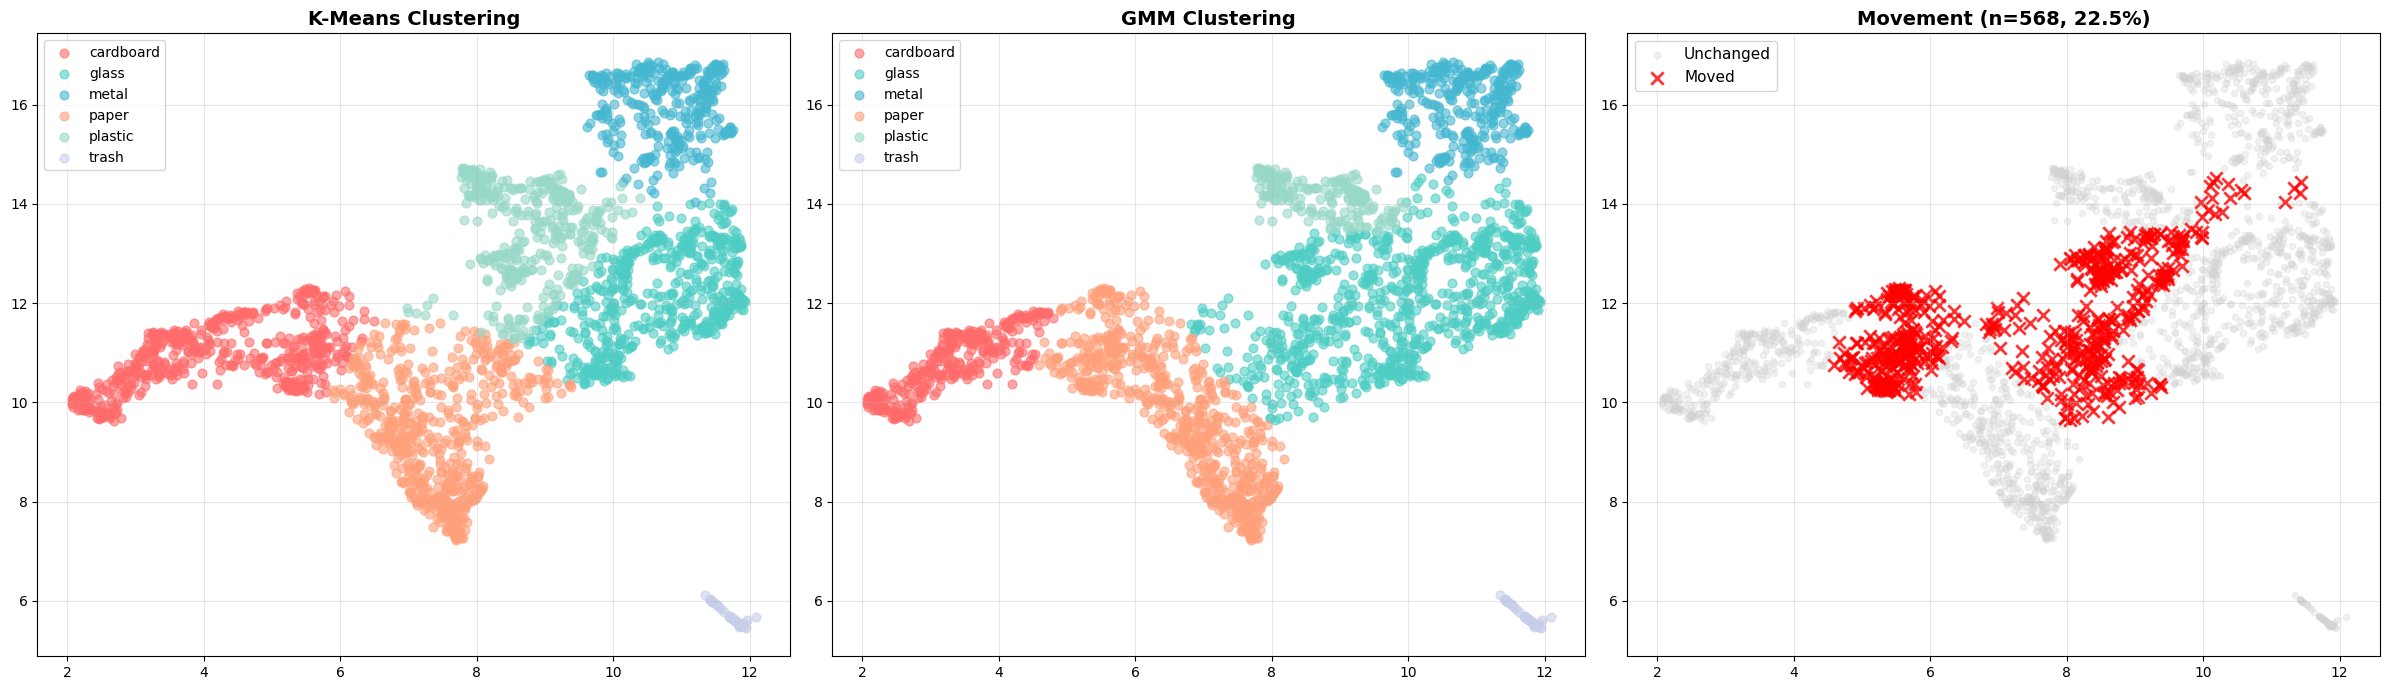

In [11]:


# Cell 6: Visualize Cluster Movement  
fig, axes = plt.subplots(1, 3, figsize=(24, 7))  

# K-Means  
for i, color in enumerate(colors):  
    mask = kmeans_aligned == i  
    axes[0].scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],   
                   c=color, label=class_names[i], alpha=0.6, s=40)  
axes[0].set_title('K-Means Clustering', fontsize=14, fontweight='bold')  
axes[0].legend(fontsize=10)  
axes[0].grid(alpha=0.3)  

# GMM  
for i, color in enumerate(colors):  
    mask = gmm_aligned == i  
    axes[1].scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],   
                   c=color, label=class_names[i], alpha=0.6, s=40)  
axes[1].set_title('GMM Clustering', fontsize=14, fontweight='bold')  
axes[1].legend(fontsize=10)  
axes[1].grid(alpha=0.3)  

# Movement  
axes[2].scatter(umap_embeddings[~moved, 0], umap_embeddings[~moved, 1],   
               c='lightgray', alpha=0.3, s=20, label='Unchanged')  
axes[2].scatter(umap_embeddings[moved, 0], umap_embeddings[moved, 1],   
               c='red', alpha=0.8, s=80, marker='x', label='Moved', linewidth=2)  
axes[2].set_title(f'Movement (n={moved.sum()}, {movement_rate:.1f}%)',   
                 fontsize=14, fontweight='bold')  
axes[2].legend(fontsize=11)  
axes[2].grid(alpha=0.3)  

plt.tight_layout()  
plt.savefig(f'{OUTPUT_DIR}/05_cluster_movement.png', dpi=300, bbox_inches='tight')  
plt.show()  


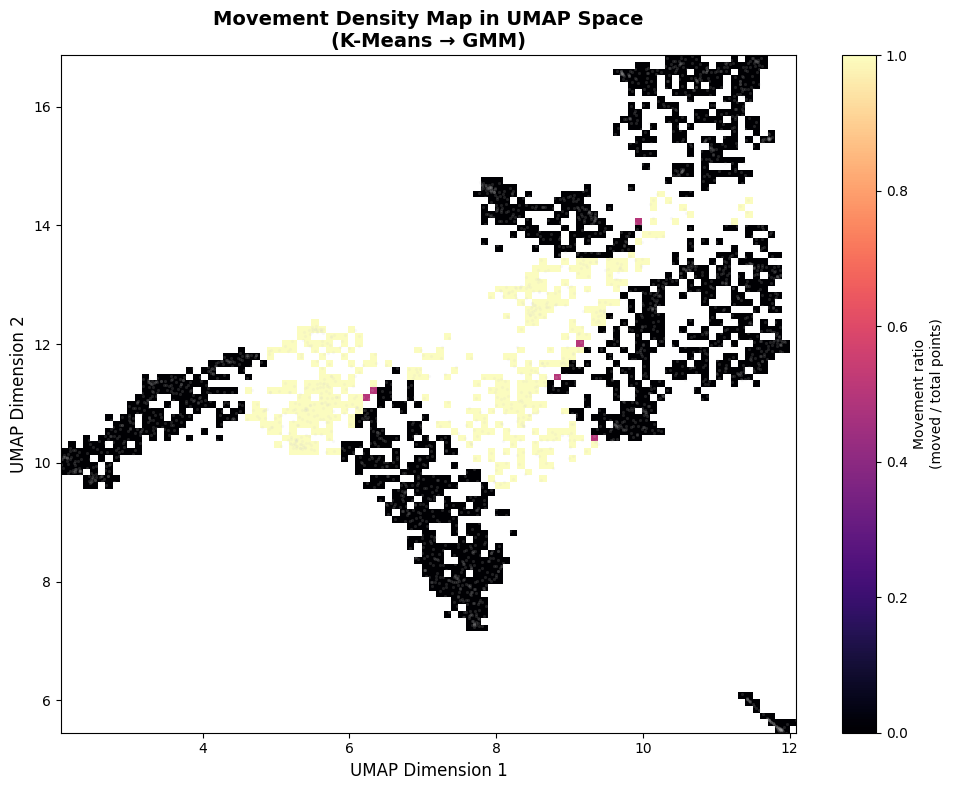

In [12]:
# Cell 7: Movement Density Map in UMAP Space
import numpy as np
import matplotlib.pyplot as plt

# Grid size for 2D histogram (higher = finer resolution, but more sparse)
GRID_SIZE = 100  


x_min, x_max = umap_embeddings[:, 0].min(), umap_embeddings[:, 0].max()
y_min, y_max = umap_embeddings[:, 1].min(), umap_embeddings[:, 1].max()


total_hist, x_edges, y_edges = np.histogram2d(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    bins=GRID_SIZE,
    range=[[x_min, x_max], [y_min, y_max]]
)


moved_hist, _, _ = np.histogram2d(
    umap_embeddings[moved, 0],
    umap_embeddings[moved, 1],
    bins=[x_edges, y_edges]
)


with np.errstate(divide='ignore', invalid='ignore'):
    movement_ratio = moved_hist / total_hist
    movement_ratio[total_hist == 0] = np.nan 

plt.figure(figsize=(10, 8))

im = plt.imshow(
    movement_ratio.T,          
    origin='lower',
    extent=[x_min, x_max, y_min, y_max],
    aspect='auto',
    cmap='magma'
)

plt.colorbar(im, label='Movement ratio\n(moved / total points)')
plt.title('Movement Density Map in UMAP Space\n(K-Means → GMM)', fontsize=14, fontweight='bold')
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)

plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    s=5, c='lightgray', alpha=0.15, linewidths=0
)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/05_movement_density_map.png', dpi=300, bbox_inches='tight')
plt.show()

Movement counts (K-Means → GMM):
           cardboard  glass  metal  paper  plastic  trash
cardboard          0      0      0    232        0      0
glass              0      0      0      0        0      0
metal              0      9      0      0        0      0
paper              0    136      0      0        0      0
plastic            0    191      0      0        0      0
trash              0      0      0      0        0      0

Row-normalized movement ratios:
           cardboard  glass  metal  paper  plastic  trash
cardboard        0.0    0.0    0.0    1.0      0.0    0.0
glass            0.0    0.0    0.0    0.0      0.0    0.0
metal            0.0    1.0    0.0    0.0      0.0    0.0
paper            0.0    1.0    0.0    0.0      0.0    0.0
plastic          0.0    1.0    0.0    0.0      0.0    0.0
trash            0.0    0.0    0.0    0.0      0.0    0.0


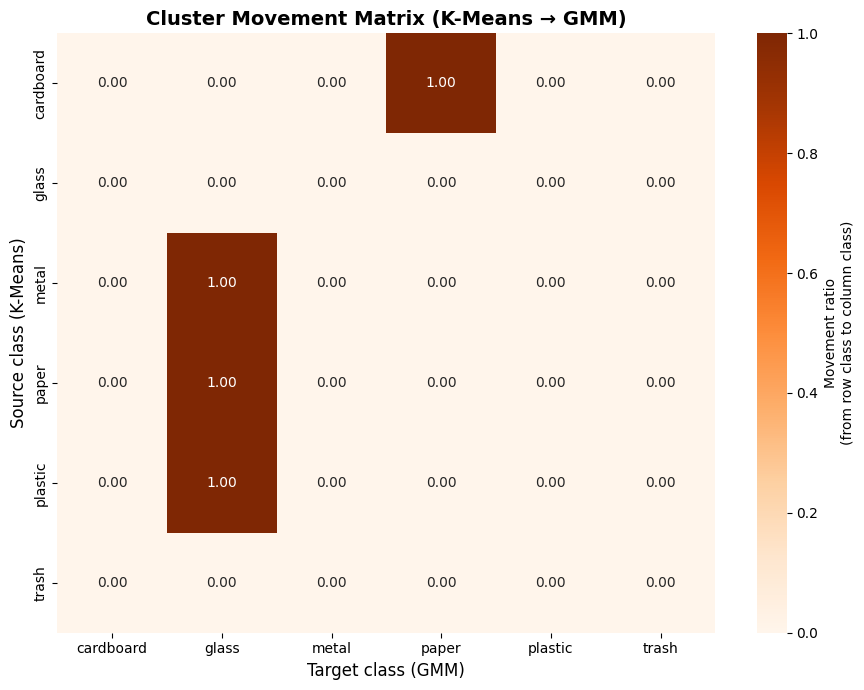

In [15]:
# Cell 8: Movement Direction Matrix (K-Means → GMM)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

n_classes = len(class_names)

# Only count points that changed assignment
source_labels = kmeans_aligned[moved]
target_labels = gmm_aligned[moved]

movement_matrix = np.zeros((n_classes, n_classes), dtype=int)
for s, t in zip(source_labels, target_labels):
    movement_matrix[s, t] += 1

# Row-normalize safely (each row sums to 1 unless the row has 0 moves)
row_sums = movement_matrix.sum(axis=1, keepdims=True)  # shape: (n_classes, 1)
movement_ratio_matrix = np.divide(
    movement_matrix,
    row_sums,
    out=np.zeros_like(movement_matrix, dtype=float),
    where=row_sums != 0
)

movement_counts_df = pd.DataFrame(movement_matrix, index=class_names, columns=class_names)
movement_ratio_df  = pd.DataFrame(movement_ratio_matrix, index=class_names, columns=class_names)

movement_counts_df.to_csv(f'{OUTPUT_DIR}/05_movement_counts_matrix.csv')
movement_ratio_df.to_csv(f'{OUTPUT_DIR}/05_movement_ratio_matrix.csv')

print("Movement counts (K-Means → GMM):")
print(movement_counts_df)

print("\nRow-normalized movement ratios:")
print(movement_ratio_df.round(3))

plt.figure(figsize=(9, 7))
ax = sns.heatmap(
    movement_ratio_df,
    annot=True,
    fmt=".2f",
    cmap='Oranges',
    cbar_kws={'label': 'Movement ratio\n(from row class to column class)'}
)
ax.set_title('Cluster Movement Matrix (K-Means → GMM)', fontsize=14, fontweight='bold')
ax.set_xlabel('Target class (GMM)', fontsize=12)
ax.set_ylabel('Source class (K-Means)', fontsize=12)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/05_movement_direction_matrix.png', dpi=300, bbox_inches='tight')
plt.show()